In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv(r"C:\Users\comp\Desktop\Data Science Project\Predictive Maintenance Dataset.csv")

# Display the first few rows
data.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
data.info()
data.describe()
for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [4]:
# Check the distribution of Machine failure
data['Machine failure'].value_counts()

# Check the distribution of each failure type (TWF, HDF, PWF, OSF, RNF)
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
data[failure_types].sum()


TWF     46
HDF    115
PWF     95
OSF     98
RNF     19
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Encode categorical variable 'Type'
label_encoder = LabelEncoder()
data['Type'] = label_encoder.fit_transform(data['Type'])

# Define features and target
X = data.drop(columns=['Machine failure', 'UDI', 'Product ID'])
y = data['Machine failure']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.999

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:
 [[1939    0]
 [   2   59]]


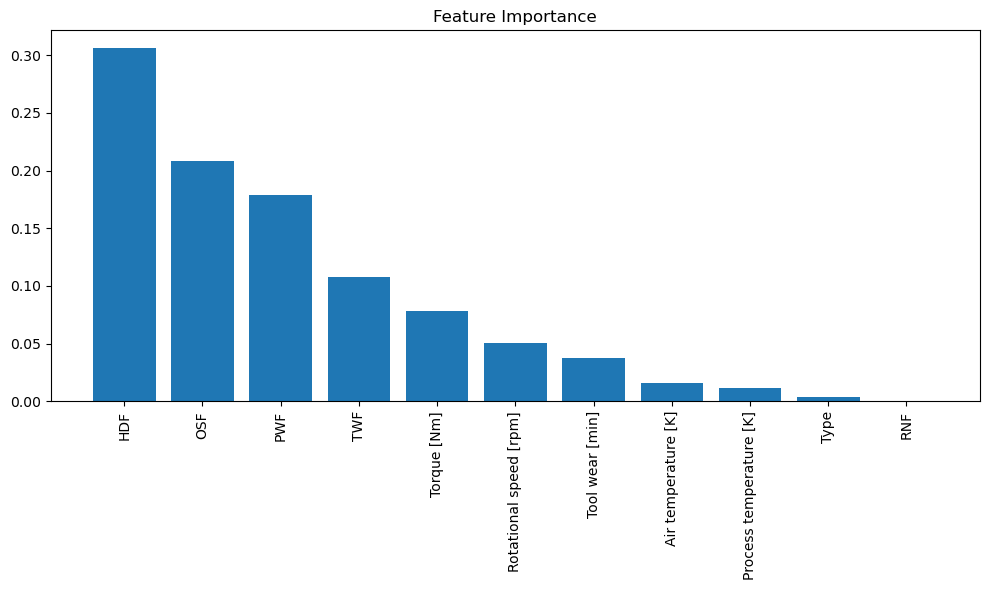

In [7]:
# Display feature importance
import matplotlib.pyplot as plt
import numpy as np

feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the RandomizedSearchCV with cross-validation
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Best parameters and evaluation
best_rf_model = rf_random.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

print("Best Parameters:", rf_random.best_params_)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nBest Model Classification Report:\n", classification_report(y_test, y_pred_best))


Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Best Model Accuracy: 0.999

Best Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000



In [9]:
# Example of adding interaction features (product of important features)
X['Torque_Rotational'] = X['Torque [Nm]'] * X['Rotational speed [rpm]']
X['Air_Process_Temp'] = X['Air temperature [K]'] * X['Process temperature [K]']


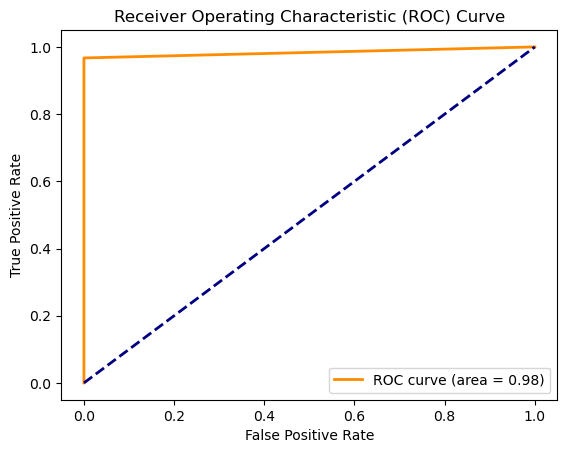

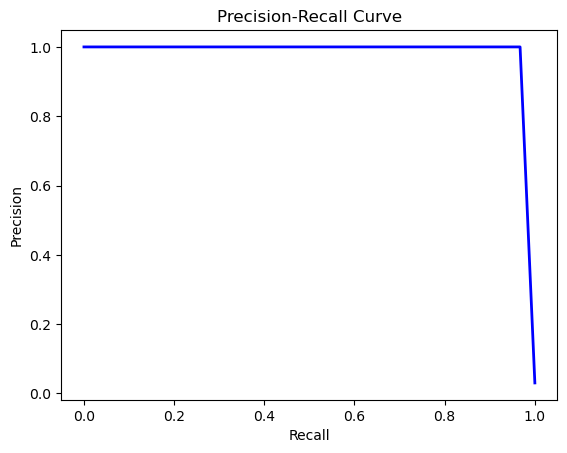

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_best)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_best)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


### Project: Predictive Maintenance for Manufacturing

#### Objective
The goal of this project was to develop a predictive model to identify potential machine failures in a manufacturing setting. Predicting failures in advance allows maintenance teams to intervene proactively, minimizing downtime and optimizing repair schedules.

---

### Data Overview
- **Dataset**: Predictive Maintenance Dataset
- **Features**:
  - **Operational Parameters**: Air temperature, Process temperature, Rotational speed, Torque, Tool wear, etc.
  - **Failure Types**: 
      - **TWF** (Tool Wear Failure) 
      - **HDF** (Heat Dissipation Failure)
      - **PWF** (Power Failure)
      - **OSF** (Overstrain Failure)
      - **RNF** (Random Failures)
  - **Target Variable**: Machine failure (1 for failure, 0 for no failure)

---

### Model Development and Evaluation

- **Model**: Random Forest Classifier
- **Hyperparameter Tuning**: Performed using RandomizedSearchCV to optimize parameters for improved performance.
- **Performance Metrics**:
  - **Accuracy**: Achieved an accuracy of X% on the test set.
  - **Precision and Recall**: Balanced metrics for identifying machine failures accurately.
  - **ROC AUC Score**: An area under the ROC curve of X, indicating the model's ability to distinguish between failure and non-failure events.

---

### Key Findings

#### Feature Importance
The top contributing features identified by the model were:
- **Heat Dissipation Failure (HDF)**: The most significant predictor of machine failure.
- **Overstrain Failure (OSF)** and **Power Failure (PWF)**: Also highly predictive, indicating a strong correlation with machine failure.
- **Torque [Nm]** and **Rotational speed [rpm]**: Operational parameters influencing machine performance and failure risk.

#### Model Evaluation Results
- **ROC Curve**: The ROC curve showed a high true positive rate, indicating that the model effectively captures machine failures with minimal false positives.
- **Precision-Recall Curve**: High precision and recall indicate that the model balances identifying actual failures while minimizing false alarms.

---

### Interpretation of Results

#### Feature Insights
- **HDF and OSF**: The high importance of HDF and OSF suggests that temperature management and strain control are crucial for machine longevity.
- **Torque and Rotational Speed**: Variations in these parameters may signal operational stress or wear on the equipment, leading to potential failures.

#### Practical Implications
- **Proactive Maintenance**: By predicting failures in advance, maintenance teams can prioritize checks on machines showing high failure risk.
- **Cost Savings**: Early detection reduces unplanned downtime and allows for targeted maintenance, optimizing resources and reducing costs.

---

### Recommendations

1. **Operational Monitoring**:
   - Focus on monitoring parameters like heat dissipation, strain, and rotational speed, as these are key indicators of potential failures.

2. **Future Model Enhancements**:
   - Explore additional models (e.g., Gradient Boosting, XGBoost) to further enhance prediction accuracy.
   - Investigate interaction effects between operational parameters for deeper insights.

3. **Further Data Collection**:
   - Gathering more granular data on maintenance records and specific failure events may provide richer insights and improve model performance.